# Preprocessing

In [1]:
import matplotlib as mpl ; mpl.rcParams['axes.unicode_minus'] = False
# import matplotlib.pyplot as plt ; plt.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt ; plt.rcParams['font.family'] = 'HYGothic-Medium'
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler
from pycaret.regression import *
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

### Public Data
code_age_gender = pd.read_csv('한국토지주택공사_임대주택 단지별 연령대별 성별정보_20210511.csv', encoding='CP949')
age_gender_info = pd.read_csv('age_gender_info.csv')
myhome_xyfill = pd.read_csv('myhome_xyfill.csv').drop_duplicates() #Crawling

In [2]:
### Function Needed

def code_name(df):
    #myhome 데이터의 필요한 부분만 긁어오기
    myhome = myhome_xyfill[['rnAdres','hsmpNm','hshldCo','suplyTyNm', '공급면적(전용)','임대보증금','임대료', 'x','y','준공일자']]
    myhome.columns= ['주소', '단지명', '총세대수', '공급유형', '전용면적','임대보증금','임대료','경도','위도','준공일자']
    #공급유형 및 지역 변수 설정
    myhome.loc[myhome['공급유형']=='50년임대', '공급유형'] = '공공임대(50년)'
    myhome.loc[myhome['공급유형']=='10년임대', '공급유형'] = '공공임대(10년)'
    myhome.loc[myhome['공급유형']=='5년임대', '공급유형'] = '공공임대(5년)'
    myhome['지역'] = myhome['주소'].str.split(' ').str[0]
    # 총세대수 -> 전용면적별세대수합 생성
    myhome_grouped = myhome[['주소','단지명','총세대수']].drop_duplicates()
    myhome_grouped = myhome_grouped.groupby(['단지명','주소'], as_index=False).sum()[['단지명','주소','총세대수']]
    myhome = pd.merge(myhome, myhome_grouped, on=['단지명','주소'], how='left')
    myhome.drop(['총세대수_x'], axis=1, inplace=True)
    myhome.rename(columns={'총세대수_y':'전용면적별세대수합'}, inplace=True)
    # First Match: 지역, 전용면적별세대수합, 공급유형, 전용면적 겹치는 것 중 유니크 382단지
    df = df.drop(['전용면적별세대수합'],axis=1)
    df = df.rename(columns={'전용면적별세대수합_myhome':'전용면적별세대수합'})
    home_merged = pd.merge(df, myhome, on=['지역', '전용면적별세대수합', '공급유형', '전용면적'])
    home_unq = home_merged.groupby(['단지코드']).nunique()
    code_unq = home_unq.index[np.where(home_unq['단지명']==1)]
    name_unq = home_merged[home_merged['단지코드'].isin(code_unq)]['단지명'].unique()
    home_unq.reset_index(drop=True, inplace=True)
    #Second Match: 지역, 공급유형, 전용면적, 임대보증금, 임대료 겹치는 것 중 전용면적별세대수 차이가 적은것
    home_unk = pd.merge(df, myhome, on=['지역','공급유형','전용면적','임대보증금','임대료'])
    home_unk = home_unk[~home_unk['단지코드'].isin(code_unq)]
    home_unk = home_unk[~home_unk['단지명'].isin(name_unq)]
    home_unk['전용면적별세대수차']=abs(home_unk['전용면적별세대수합_x']-home_unk['전용면적별세대수합_y'])
    home_unk = home_unk.groupby(['단지코드','단지명','주소','위도','경도','준공일자','전용면적별세대수차']).nunique('전용면적')['전용면적'].reset_index()
    home_unk = home_unk.loc[home_unk.groupby('단지코드').전용면적별세대수차.idxmin()]

    first_match = home_merged[home_merged['단지코드'].isin(code_unq)][['단지명','단지코드','주소','위도','경도','준공일자']].drop_duplicates()
    second_match = home_unk[['단지명','단지코드','주소','위도','경도','준공일자']].drop_duplicates()
    match = pd.concat([first_match, second_match],axis=0).reset_index(drop=True)

    # Final Match: 남은 것중에 지역과 공급유형이 동일하고 전용면적별세대수합 차이가 가장 적은것
    for_match = df[~df['단지코드'].isin(match['단지코드'])][['단지코드','지역','공급유형','전용면적별세대수합']].drop_duplicates()
    list_match =[]
  
    for code in for_match['단지코드'].unique():
        for_dict = for_match[for_match['단지코드']==code]
        rg = list(for_dict['지역'].values)
        sp = list(for_dict['공급유형'].values)
        if (sp[0]=='공공임대(분납)'):
            sp = ['공공임대(10년)'] # Myhome에는 공공임대(분납)이 없으므로
        nh = list(for_dict['전용면적별세대수합'].values)[0]
        myhome_match = myhome[(myhome['지역'].isin(rg))&(myhome['공급유형'].isin(sp))]
        myhome_match = list(myhome_match.loc[abs(myhome_match['전용면적별세대수합']-nh).idxmin()][['단지명','주소','위도','경도','준공일자']])
        list_match.append([code]+myhome_match)

    final_match = pd.DataFrame(list_match, columns=['단지코드','단지명','주소','위도','경도','준공일자'])
    match = pd.concat([match, final_match],axis=0).reset_index(drop=True)
    df = pd.merge(df, match, on=['단지코드'])
    df = df.fillna('0')
    return(df)

def total_member(df):
    age_gender = code_age_gender[code_age_gender['주택유형']=='아파트']
    age_gender = age_gender.iloc[:,5:].groupby(['도로명주소']).sum().reset_index().merge(age_gender[['주택명','도로명주소']].drop_duplicates().groupby(['도로명주소']).first().reset_index(), on='도로명주소', how='left')
    age_gender.rename(columns={'도로명주소':'주소', '주택명':'단지명'}, inplace=True)
    age_gender = age_gender[age_gender.주소.notnull()]
    age_gender = age_gender.drop_duplicates().reset_index(drop=True)
    age_gender = age_gender.drop(['총세대수'], axis=1)
    age_gender['총입주민수'] = age_gender.set_index(['단지명','주소']).apply(sum,axis=1).values
    age_gender = age_gender.drop(['단지명'], axis=1)
    age_gender.loc[:,age_gender.columns.str.contains('대')] = age_gender.loc[:,age_gender.columns.str.contains('대')].mul(1/age_gender['총입주민수'], axis=0)
    df = pd.merge(df, age_gender, on=['주소'], how='left')
    na_not_df = df[df.notnull().all(axis=1)]
    na_df = df[df.isnull().any(axis=1)].loc[:,~df.columns.str.contains('0대')]
    na_df = na_df.reset_index().merge(age_gender_info, on='지역').set_index('index')
    na_df = na_df.drop(['총입주민수'], axis=1)
    mult = np.mean(na_not_df['총입주민수'] / na_not_df['총세대수'])
    na_df['총입주민수'] = na_df['총세대수'] * mult
    df = pd.concat([na_df, na_not_df],axis=0).sort_index().reset_index(drop=True)
    return(df)

In [3]:
# Train Data 불러오기 및 오류 데이터 제거
train = pd.read_csv('train.csv')
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)
test = pd.read_csv('test.csv')
test_error = ['C2675', 'C2335', 'C1327']
test = test[~test['단지코드'].isin(test_error)].reset_index(drop=True)
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 15) | Test Set: (1008, 14)


In [4]:
# '임대보증금', '임대료'의 '-'를 0으로 변환
train['임대보증금'] = train['임대보증금'].replace('-', 0).astype('float64')
train['임대료'] = train['임대료'].replace('-', 0).astype('float64')
test['임대보증금'] = test['임대보증금'].replace('-', 0).astype('float64')
test['임대료'] = test['임대료'].replace('-', 0).astype('float64')
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 15) | Test Set: (1008, 14)


In [5]:
# Train Data의 '임대보증금', '임대료' NA를 0으로 대체
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
print(f'Train Set: {train.shape}')

Train Set: (2869, 15)


In [6]:
# Test Data의 '임대보증금', '임대료' NA를 특정값으로 대체
test.loc[test['임대건물구분'] == '상가', ['임대보증금', '임대료']] = test.loc[test['임대건물구분'] == '상가', ['임대보증금', '임대료']].fillna(0)
test.loc[test['임대보증금'].isnull(), '임대보증금'] = [5787000.0, 5787000.0, 11574000.0]
test.loc[test['임대료'].isnull(), '임대료'] = [79980.0, 79980.0, 159960.0]
print(f'Test Set: {test.shape}')

Test Set: (1008, 14)


In [7]:
# Test Data의 '단지코드' NA를 특정값으로 대체
test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'
test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'
print(f'Test Set: {test.shape}')

Test Set: (1008, 14)


In [8]:
# '도보 10분거리 내 지하철역 수(환승노선 수 반영)'의 NA를 0으로 대체
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 15) | Test Set: (1008, 14)


In [9]:
print(f'Train Set NA: {sum(train.isnull().sum())} | Test Set NA: {sum(test.isnull().sum())}')

Train Set NA: 0 | Test Set NA: 0


---

In [10]:
# '전용면적별세대수합' 변수 생성
noh_by_area = train.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
train = pd.merge(left=train, right=noh_by_area, how='left', on='단지코드')
noh_by_area = test.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
test = pd.merge(left=test, right=noh_by_area, how='left', on='단지코드')
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

# '전용면적별세대수합_myhome' 변수 생성
train_myhome = train[train['공급유형']!='공공분양']
noh_by_area = train_myhome.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합_myhome'})
train = pd.merge(left=train, right=noh_by_area, how='left', on='단지코드')

test_myhome = test[test['공급유형']!='공공분양']
noh_by_area = test_myhome.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합_myhome'})
test = pd.merge(left=test, right=noh_by_area, how='left', on='단지코드')
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 16) | Test Set: (1008, 15)
Train Set: (2869, 17) | Test Set: (1008, 16)


In [11]:
# '임대보증금가중평균', '임대료가중평균' 변수 생성
train['임대보증금가중평균'] = round(train['임대보증금'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'임대보증금가중평균':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['임대보증금가중평균_x'], axis=1).rename(columns={'임대보증금가중평균_y':'임대보증금가중평균'})
train['임대료가중평균'] = round(train['임대료'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'임대료가중평균':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['임대료가중평균_x'], axis=1).rename(columns={'임대료가중평균_y':'임대료가중평균'})
test['임대보증금가중평균'] = round(test['임대보증금'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'임대보증금가중평균':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['임대보증금가중평균_x'], axis=1).rename(columns={'임대보증금가중평균_y':'임대보증금가중평균'})
test['임대료가중평균'] = round(test['임대료'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'임대료가중평균':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['임대료가중평균_x'], axis=1).rename(columns={'임대료가중평균_y':'임대료가중평균'})
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 19) | Test Set: (1008, 18)


In [12]:
# '소형세대' 변수 생성
train['세대구분'] = ['소형세대' if i < 40 else '기타세대' for i in train['전용면적']]
household = train.groupby(['단지코드', '세대구분'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '세대구분', '전용면적별세대수').fillna(0).reset_index().drop(['기타세대'], axis=1)
train = pd.merge(train, household, how='left').drop(['세대구분'], axis=1)
train['소형세대'] = train['소형세대'] / train['전용면적별세대수합']
test['세대구분'] = ['소형세대' if i < 40 else '기타세대' for i in test['전용면적']]
household = test.groupby(['단지코드', '세대구분'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '세대구분', '전용면적별세대수').fillna(0).reset_index().drop(['기타세대'], axis=1)
test = pd.merge(test, household, how='left').drop(['세대구분'], axis=1)
test['소형세대'] = test['소형세대'] / test['전용면적별세대수합']
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 20) | Test Set: (1008, 19)


In [13]:
# '전용면적가중평균' 변수 생성
train['전용면적가중평균'] = round(train['전용면적'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'전용면적가중평균':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['전용면적가중평균_x'], axis=1).rename(columns={'전용면적가중평균_y':'전용면적가중평균'})
test['전용면적가중평균'] = round(test['전용면적'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'전용면적가중평균':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['전용면적가중평균_x'], axis=1).rename(columns={'전용면적가중평균_y':'전용면적가중평균'})
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 21) | Test Set: (1008, 20)


In [14]:
# '차량보유인구비율' 변수 생성
age_gender_info = pd.read_csv('age_gender_info.csv')
cars = pd.DataFrame(age_gender_info.iloc[:, [7, 8, 9, 10, 12, 14]].sum(axis=1), columns=['차량보유인구비율'])
cars['지역'] = age_gender_info['지역']
train = pd.merge(train, cars, how='left', on='지역')
test = pd.merge(test, cars, how='left', on='지역')
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 22) | Test Set: (1008, 21)


In [15]:
# '차량미보유세대비율' 변수 생성
noh_wo_cars = train[train['공급유형'].isin(['영구임대', '행복주택'])].groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'차량미보유세대비율'})
train = pd.merge(train, noh_wo_cars, how='left')
train['차량미보유세대비율'] = train['차량미보유세대비율'].fillna(0) / train['총세대수']
noh_wo_cars = test[test['공급유형'].isin(['영구임대', '행복주택'])].groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'차량미보유세대비율'})
test = pd.merge(test, noh_wo_cars, how='left')
test['차량미보유세대비율'] = test['차량미보유세대비율'].fillna(0) / test['총세대수']
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 23) | Test Set: (1008, 22)


In [16]:
# 단지명, 주소, 위도, 경도, 준공일자 생성
train = code_name(train)
train = total_member(train)

test = code_name(test)
test = total_member(test)

print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 50) | Test Set: (1008, 49)


---

**여기에 '준공후기간(월)' 변수 넣는 코드 추가하면 됨!**

In [17]:
#준공후 현재까지의 시간 차이를 월단위로 계산한 '준공후기간(월)' 변수 생성
def add_build_date(df):
    #준공일자 글자길이 7이면 (ex. 2020-01 까지만 존재)'-01' 추가해주기
    df.loc[df['준공일자'].str.len()==7, '준공일자'] = df.loc[df['준공일자'].str.len()==7, '준공일자']+str('-01')
    #준공일자 글자길이 5이면 (ex. 2020- 까지만 존재)-01-01'추가해주기
    df.loc[df['준공일자'].str.len()==5, '준공일자'] = df.loc[df['준공일자'].str.len()==5, '준공일자']+str('01-01')
    df.loc[df['준공일자'].notnull(),'준공일자'] = df.loc[df['준공일자'].notnull(),'준공일자'].str.replace('-','').astype('int64')
    #준공일자 지나치게 오래된것은 오류로 기입된 것이라 판단, NA로 대체.
    df.loc[df['준공일자']<=19700101, '준공일자'] = np.nan
    
    df.loc[df['준공일자'].notnull(),'년'] = df.loc[df['준공일자'].notnull(),'준공일자']//10000
    df.loc[df['준공일자'].notnull(),'월'] = df.loc[df['준공일자'].notnull(),'준공일자']//100 - df.loc[df['준공일자'].notnull(),'년']*100
    df.loc[df['준공일자'].notnull(),'준공후기간(월)'] = 2021*12 + 7 -(df.loc[df['준공일자'].notnull(),'년']*12 + df.loc[df['준공일자'].notnull(),'월'])
    df = df.drop(['준공일자', '년', '월'], axis=1)
    return(df)

In [18]:
train = add_build_date(train)
test = add_build_date(test)
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 50) | Test Set: (1008, 49)


In [19]:
# '준공후기간(월)' 변수 NA값 대치 위해 '입주후기간(월)' 변수 생성
# '입주후기간(월)' 변수 생성 위해 데이터 불러오기
data = pd.read_csv('임대주택_단지_조회.csv')
data.drop(['순번', '전체건수'], axis=1, inplace=True)
data['전용면적'] = np.round(data['전용면적'], 2)
data = data.rename(columns={'단지명': '단지명2'})
data['지역'] = ['세종특별자치시' if i[0] == '세종시' else i[0] for i in data['지역'].str.split()]
noh_by_area = data.groupby('단지명2', as_index=False).agg({'전용면적별세대수':'sum'})
noh_by_area.columns = ['단지명2', '전용면적별세대수합']
data = pd.merge(left=data, right=noh_by_area, how='left', on='단지명2')
data.drop(['총세대수'], axis=1, inplace=True)

in_date = data[['단지명2', '최초입주년월']].drop_duplicates().reset_index(drop=True)
in_date.loc[(in_date['최초입주년월']<198001)|(in_date['최초입주년월']>=202107),'최초입주년월']=np.nan
in_date.loc[in_date['최초입주년월'].notnull(), '년'] = in_date.loc[in_date['최초입주년월'].notnull(), '최초입주년월'] //100
in_date.loc[in_date['최초입주년월'].notnull(), '월'] = in_date.loc[in_date['최초입주년월'].notnull(), '최초입주년월'] % 100
in_date.loc[in_date['최초입주년월'].notnull(), '입주후기간(월)'] = 2021*12+ 7 - (in_date.loc[in_date['최초입주년월'].notnull(), '년']*12 + in_date.loc[in_date['최초입주년월'].notnull(), '월'])
in_date = in_date.drop(['최초입주년월', '년', '월'], axis=1)
in_date['입주후기간(월)'] = in_date['입주후기간(월)'].astype('float64')
data = pd.merge(data, in_date, how='left', on='단지명2')

In [20]:
#'입주후기간(월)' 변수 생성
def add_in_date(df):
    df_wo_dup = df.drop_duplicates(subset=['단지코드'])[['단지코드', '지역', '전용면적별세대수합']].reset_index(drop=True)
    idx = np.column_stack([df.drop_duplicates(subset=['단지코드'])[['지역', '전용면적별세대수합']].reset_index(drop=True), range(len(df_wo_dup))])
    df_wo_dup['단지명2'] = None
    df_wo_dup['입주후기간(월)'] = None
    for i, j, k in idx:
        if data.loc[(data['지역'] == i) & (data['전용면적별세대수합'] == j), '단지명2'].nunique() == 1:
            df_wo_dup.iloc[k, df_wo_dup.columns.get_loc('단지명2')] = data.loc[(data['지역'] == i) & (data['전용면적별세대수합'] == j), '단지명2'].unique()[0]
            df_wo_dup.iloc[k, df_wo_dup.columns.get_loc('입주후기간(월)')] = data.loc[(data['지역'] == i) & (data['전용면적별세대수합'] == j), '입주후기간(월)'].unique()[0]
    
    null = df_wo_dup[df_wo_dup['단지명2'].isnull()].reset_index(drop=True) #단지명 안붙은애들 null로 저장
    data_hhset = data[['단지명2', '전용면적']].groupby(['단지명2'])['전용면적'].apply(list) 
    data_hhset = pd.DataFrame(data_hhset)
    data_hhset = pd.merge(data_hhset, data[['단지명2', '지역', '전용면적별세대수합', '입주후기간(월)']], on='단지명2')
    data_hhset = data_hhset[['단지명2', '지역', '전용면적별세대수합', '전용면적','입주후기간(월)']]
    data_hhset = data_hhset.drop_duplicates(['단지명2']).reset_index(drop=True)

    idx = null['단지코드'].unique()
    for i in range(len(idx)):
        areaset_df = set(df.loc[df['단지코드'] == idx[i], '전용면적'])
        region = null.loc[i, '지역']
        total_hh2 = null.loc[i,'전용면적별세대수합']
        same = data_hhset.loc[(data_hhset['지역'] == region) & (data_hhset['전용면적별세대수합'] == total_hh2)].reset_index(drop=True)
        diff = []
        if len(same.index) != 0:
            for j in range(len(same)):
                areaset_data = set(same.loc[j, '전용면적'])
                diff.append(len(areaset_df - areaset_data))
            null.loc[i, '단지명2'] = same.loc[np.argmin(diff), '단지명2']
            null.loc[i, '입주후기간(월)'] = same.loc[np.argmin(diff), '입주후기간(월)']

    for i in range(len(df_wo_dup)):
        if df_wo_dup.iloc[i, df_wo_dup.columns.get_loc('단지명2')] == None:
            df_wo_dup.iloc[i, df_wo_dup.columns.get_loc('단지명2')] = null.loc[null['단지코드'] == df_wo_dup.iloc[i, df_wo_dup.columns.get_loc('단지코드')], '단지명2']
            df_wo_dup.iloc[i, df_wo_dup.columns.get_loc('입주후기간(월)')] = null.loc[null['단지코드'] == df_wo_dup.iloc[i, df_wo_dup.columns.get_loc('단지코드')], '입주후기간(월)']
        else:
            pass

    df = pd.merge(df, df_wo_dup[['단지코드', '단지명2', '입주후기간(월)']], how='left', on='단지코드')

    code_name = df['단지코드'].unique()
    for i in range(len(code_name)):
        dat = df.loc[df['단지코드'] == code_name[i],:]
        if (dat.shape[0] != dat.단지명2.isnull().sum()) & (dat.shape[0] != dat.단지명2.notnull().sum()):
            df.loc[df['단지코드'] == code_name[i],'단지명2'] = dat.loc[dat['단지명2'].notnull(),'단지명2']
            df.loc[df['단지코드'] == code_name[i],'입주후기간(월)'] = dat.loc[dat['단지명2'].notnull(),'입주후기간(월)']
        else:
            pass
    
    df['입주후기간(월)'] = df['입주후기간(월)'].astype('float64')
    df.reset_index(drop=True, inplace=True)
    print(round(df.loc[df['단지명2'].isnull(), '단지코드'].nunique()/df['단지코드'].nunique(), 2)*100)
    return(df)

In [21]:
train = add_in_date(train)
test = add_in_date(test)
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

17.0
11.0
Train Set: (2869, 52) | Test Set: (1008, 51)


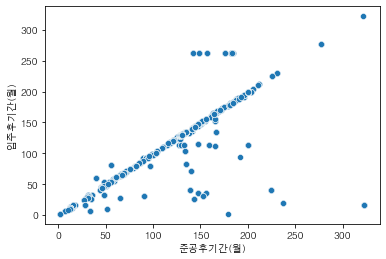

In [22]:
# 준공후기간(월)과 입주후기간(월)이 대체로 일치하는 것을 확인할 수 있음
sns.scatterplot(x ='준공후기간(월)', y = '입주후기간(월)', data = train)
plt.show()

In [23]:
# 준공후기간(월)의 NA값들 입주후기간(월)로 imputation 후 필요없는 column들 제거
train.loc[(train['준공후기간(월)'].isnull())&(train['입주후기간(월)'].notnull()), '준공후기간(월)']= train.loc[(train['준공후기간(월)'].isnull())&(train['입주후기간(월)'].notnull()), '입주후기간(월)']
test.loc[(test['준공후기간(월)'].isnull())&(test['입주후기간(월)'].notnull()), '준공후기간(월)']= test.loc[(test['준공후기간(월)'].isnull())&(test['입주후기간(월)'].notnull()), '입주후기간(월)']
train = train.drop(['단지명2', '입주후기간(월)'], axis=1)
test = test.drop(['단지명2', '입주후기간(월)'], axis=1)
print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 50) | Test Set: (1008, 49)


In [24]:
# '준공후기간(월)' Imputation
from impyute.imputation.cs import mice
def date_impute(df):
    df['준공후기간(월)']=df['준공후기간(월)'].astype('float64')
    df_num = df.loc[:,df.dtypes!=object]
    df_imp = mice(df_num.values)
    df_imp = pd.DataFrame(df_imp)
    df_imp.columns = df_num.columns
    df['준공후기간(월)'] = df_imp['준공후기간(월)']
    return(df)

In [25]:
train = date_impute(train)
test = date_impute(test)

---

In [26]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

supply_type = train.groupby(['단지코드', '공급유형'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '공급유형', '전용면적별세대수').fillna(0).reset_index()
supply_type.set_index('단지코드', inplace=True)
supply_type[(supply_type != 0)] = 1
supply_type.reset_index(inplace=True)

qual_type = train.groupby(['단지코드', '자격유형'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '자격유형', '전용면적별세대수').fillna(0).reset_index()
qual_type.set_index('단지코드', inplace=True)
qual_type[(qual_type != 0)] = 1
qual_type.reset_index(inplace=True)

build_type = train.groupby(['단지코드', '임대건물구분'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '임대건물구분', '전용면적별세대수').fillna(0).reset_index()
build_type.set_index('단지코드', inplace=True)
build_type[(build_type != 0)] = 1
build_type.reset_index(inplace=True)

train = pd.merge(train, supply_type, how='left')
train = pd.merge(train, qual_type, how='left')
train = pd.merge(train, build_type, how='left')

supply_type = test.groupby(['단지코드', '공급유형'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '공급유형', '전용면적별세대수').fillna(0).reset_index()
supply_type.set_index('단지코드', inplace=True)
supply_type[(supply_type != 0)] = 1
supply_type.reset_index(inplace=True)

qual_type = test.groupby(['단지코드', '자격유형'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '자격유형', '전용면적별세대수').fillna(0).reset_index()
qual_type.set_index('단지코드', inplace=True)
qual_type[(qual_type != 0)] = 1
qual_type.reset_index(inplace=True)

build_type = test.groupby(['단지코드', '임대건물구분'], as_index=False).agg({'전용면적별세대수':'sum'}).pivot('단지코드', '임대건물구분', '전용면적별세대수').fillna(0).reset_index()
build_type.set_index('단지코드', inplace=True)
build_type[(build_type != 0)] = 1
build_type.reset_index(inplace=True)

test = pd.merge(test, supply_type, how='left')
test = pd.merge(test, qual_type, how='left')
test = pd.merge(test, build_type, how='left')

print(f'Train Set: {train.shape} | Test Set: {test.shape}')

Train Set: (2869, 63) | Test Set: (1008, 62)


In [27]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,전용면적별세대수합,임대보증금가중평균,임대료가중평균,소형세대,전용면적가중평균,차량보유인구비율,차량미보유세대비율,단지명,주소,위도,경도,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),총입주민수,준공후기간(월),공공임대(50년),공공임대(5년/10년/분납/분양),국민임대/장기전세,영구임대,임대상가,행복주택,A,D,국민임대/장기전세_공급대상,영구임대_공급대상,행복주택_공급대상,상가,아파트
0,C2515,545,아파트,경상남도,국민임대/장기전세,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0,545,14035965.0,119432.0,0.653211,39.0,0.400787,0.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,34.825605,128.395943,0.021739,0.025084,0.077759,0.069398,0.05602,0.068562,0.04097,0.038462,0.074415,0.061873,0.08612,0.070234,0.077759,0.099498,0.047659,0.035117,0.031773,0.010033,0.005853,0.001672,0.0,0.0,1196.0,133.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,C2515,545,아파트,경상남도,국민임대/장기전세,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,545,14035965.0,119432.0,0.653211,39.0,0.400787,0.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,34.825605,128.395943,0.021739,0.025084,0.077759,0.069398,0.05602,0.068562,0.04097,0.038462,0.074415,0.061873,0.08612,0.070234,0.077759,0.099498,0.047659,0.035117,0.031773,0.010033,0.005853,0.001672,0.0,0.0,1196.0,133.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,C2515,545,아파트,경상남도,국민임대/장기전세,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,545,14035965.0,119432.0,0.653211,39.0,0.400787,0.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,34.825605,128.395943,0.021739,0.025084,0.077759,0.069398,0.05602,0.068562,0.04097,0.038462,0.074415,0.061873,0.08612,0.070234,0.077759,0.099498,0.047659,0.035117,0.031773,0.010033,0.005853,0.001672,0.0,0.0,1196.0,133.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,C2515,545,아파트,경상남도,국민임대/장기전세,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,545,14035965.0,119432.0,0.653211,39.0,0.400787,0.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,34.825605,128.395943,0.021739,0.025084,0.077759,0.069398,0.05602,0.068562,0.04097,0.038462,0.074415,0.061873,0.08612,0.070234,0.077759,0.099498,0.047659,0.035117,0.031773,0.010033,0.005853,0.001672,0.0,0.0,1196.0,133.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,C2515,545,아파트,경상남도,국민임대/장기전세,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,545,14035965.0,119432.0,0.653211,39.0,0.400787,0.0,미수휴먼시아,경상남도 통영시 미우지해안로 107,34.825605,128.395943,0.021739,0.025084,0.077759,0.069398,0.05602,0.068562,0.04097,0.038462,0.074415,0.061873,0.08612,0.070234,0.077759,0.099498,0.047659,0.035117,0.031773,0.010033,0.005853,0.001672,0.0,0.0,1196.0,133.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**여기까지 작업 완료**

---

In [28]:
X_train = X_train.set_index('단지코드')
X_test = X_test.set_index('단지코드')

NameError: name 'X_train' is not defined

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

In [ ]:
print(X_train.shape); print(X_test.shape)

In [ ]:
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]

In [ ]:
print(X_train.shape); print(X_test.shape)

In [ ]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

In [ ]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료', '총입주민수', '준공후기간(월)',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std']

In [ ]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [ ]:
# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [ ]:
# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료', '총입주민수', '준공후기간(월)',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

In [ ]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

# Modeling

In [ ]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [ ]:
cat.fit(X, y, verbose = 0)
pred = cat.predict(X_test)

In [ ]:
submission = pd.DataFrame(columns=['code', 'num'])
submission['code']= X_test.index
submission['num']= pred
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
submission = pd.concat([submission, error]).reset_index(drop=True)

In [ ]:
submission['num'] = submission['num'].astype('float64')
submission.loc[submission['num']<0,'num'] = 0
submission.to_csv('submission_cat6.csv', index=False)

In [ ]:
from catboost import Pool
train_pool = Pool(X, y)

In [ ]:
data = pd.DataFrame({'feature_importance': cat.get_feature_importance(train_pool), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
score = cross_val_score(cat, X, y, cv=kfold, scoring='neg_mean_absolute_error')

In [ ]:
print(f'평균: {-score.mean()} | 표준편차: {score.std()}')

In [ ]:
X.shape

#### feature selection 안한 ver. public score :87.2994749246

---
---